## Задание № 7

### Урок 7. Классификация с помощью KNN. Кластеризация K-means

#### Задание

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.
2. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. **Сделать выводы**.
3. Настроить оптимальное значение числа соседей для моделей из п.1 и п.2. **Cделать выводы**.
4. **(опция)** Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

> Построим ООП модель алгоритма


In [1]:
from abc import ABC

import numpy as np
from sklearn import model_selection

> определим абстракный класс метрики расстояния

In [2]:
class FuncDist(ABC):
    def calc(self, x1, x2):
        pass


> определим класс модели kNN

In [3]:
class GbKnn:
    eta = 0
    qu = 0
    k_neighbours = 0

    X_train = None
    X_test = None
    y_train = None
    y_test = None

    func_dist = None

    def __init__(self, X, y, func_dist: FuncDist, k_neighbours=1, test_size=0.25, eta=1, qu=0.5):
        self.params(k_neighbours=k_neighbours, eta=eta, qu=qu)
        # разделение выборки встроено в класс
        self.X_train, self.X_test, self.y_train, self.y_test = model_selection.train_test_split(X, y,
                                                                                                test_size=test_size,
                                                                                                random_state=1)
        self.func_dist = func_dist

    def params(self, k_neighbours=1, eta=1, qu=0.5):
        self.k_neighbours = k_neighbours
        self.eta = eta
        self.qu = qu

    def predict(self):
        answers = []
        for x in self.X_test:
            test_distances = []

            for i in range(len(self.X_train)):
                # расчет расстояния от классифицируемого объекта до
                # объекта обучающей выборки
                distance = self.func_dist.calc(x, self.X_train[i])

                # Записываем в список значение расстояния и ответа на объекте обучающей выборки
                test_distances.append((distance, self.y_train[i]))

            # создаем словарь со всеми возможными классами
            classes = {class_item: 0 for class_item in set(self.y_train)}

            test_distances = self.ordered(test_distances)
            # print(test_distances)

            # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
            for d in test_distances[0:self.k_neighbours]:
                classes[d[1]] += 1

            # Записываем в список ответов наиболее часто встречающийся класс
            answers.append(sorted(classes, key=classes.get)[-1])
        return answers

    def accuracy(self, pred, y):
        return (sum(pred == y) / len(y))

    def quality(self, pred):
        return self.accuracy(pred, self.y_test)

    # шаблонный метод расчета расстояния
    def ordered(self, distance):
        return sorted(distance)

> Определим конкретный класс расчета Евклидовой метрики расстояния

In [4]:
class EvMetDist(FuncDist):
    def calc(self, x1, x2):
        distance = 0
        for i in range(len(x1)):
            distance += np.square(x1[i] - x2[i])

        return np.sqrt(distance)


> переопределим шаблонный метод расчета расстояний с учетом весов, которые зависят от номера по удаленности

In [5]:
class GbKnnWNum(GbKnn):

    def ordered(self, distance):
        w_distance = []
        for i, (d, y) in enumerate(sorted(distance)):
            w_distance.append((d * (1 / (i + 1)), y))
        return sorted(w_distance, reverse=True)


> переопределим шаблонный метод расчета расстояний с учетом весов, которые зависят от расстояния


In [6]:
class GbKnnWDist(GbKnn):

    def ordered(self, distance):
        w_distance = []
        for i, (d, y) in enumerate(distance):
            w_distance.append((self.qu ** d, y))
        return sorted(w_distance, reverse=True)


Загрузим один из "игрушечных" датасетов из sklearn.

In [63]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

In [64]:
# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

### Задание 1.


In [48]:
gbknn1 = GbKnn(X, y, EvMetDist(), test_size=0.2, k_neighbours=4)
gbknn1.quality(gbknn1.predict())

0.8333333333333334

In [49]:
gbknn2 = GbKnnWNum(X, y, EvMetDist(), test_size=0.2, k_neighbours=4)
gbknn2.quality(gbknn2.predict())

0.7333333333333333

In [50]:
ex1_pred1 = []
ex1_pred2 = []
for k in range(1, 10 + 1):
    gbknn1.params(k_neighbours=k)
    gbknn2.params(k_neighbours=k)
    ex1_pred1.append([k, gbknn1.quality(gbknn1.predict())])
    ex1_pred2.append([k, gbknn2.quality(gbknn2.predict())])
ex1_pred1 = np.array(ex1_pred1)
ex1_pred2 = np.array(ex1_pred2)

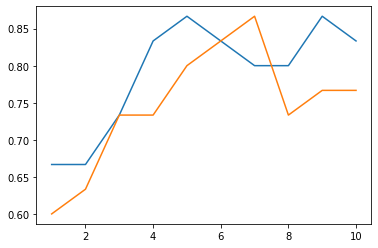

In [51]:
from matplotlib import pyplot as plt

plt.plot(ex1_pred1[:, :1], ex1_pred1[:, 1:2])
plt.plot(ex1_pred2[:, :1], ex1_pred2[:, 1:2])
plt.show()


> алгоритм с весами более устойчив к параметру соседи и
> имеет один максимум точности при количестве соседей равных 7

### Задание 2.


In [52]:
gbknn1 = GbKnn(X, y, EvMetDist(), test_size=0.2, k_neighbours=4)
gbknn1.quality(gbknn1.predict())

0.8333333333333334

In [53]:
gbknn2 = GbKnnWDist(X, y, EvMetDist(), test_size=0.2, k_neighbours=4)
gbknn2.quality(gbknn2.predict())

0.7666666666666667

In [54]:
ex1_pred1 = []
ex1_pred2 = []
for k in range(1, 10 + 1):
    gbknn1.params(k_neighbours=k)
    gbknn2.params(k_neighbours=k)
    ex1_pred1.append([k, gbknn1.quality(gbknn1.predict())])
    ex1_pred2.append([k, gbknn2.quality(gbknn2.predict())])
ex1_pred1 = np.array(ex1_pred1)
ex1_pred2 = np.array(ex1_pred2)

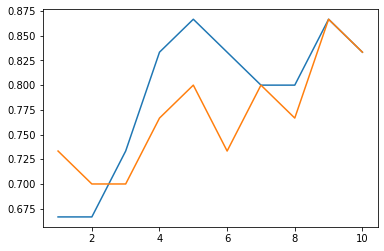

In [55]:
from matplotlib import pyplot as plt

plt.plot(ex1_pred1[:, :1], ex1_pred1[:, 1:2])
plt.plot(ex1_pred2[:, :1], ex1_pred2[:, 1:2])
plt.show()


> алгоритм с весами более устойчив к параметру соседи и
> имеет один максимум точности при количестве соседей равных 9

> Исследуем зависимость алгоритма от параметра Q при расчете весов
> в зависимости от расстояния при фиксированном количестве соседей

In [74]:
gbknn2 = GbKnnWDist(X, y, EvMetDist(), test_size=0.2, k_neighbours=4)
ex2_pred1 = []
for q in np.arange(0.1, 1, 0.1):
    gbknn2.params(qu=q, k_neighbours=5)
    ex2_pred1.append([q, gbknn2.quality(gbknn2.predict())])
ex2_pred1 = np.array(ex2_pred1)
ex2_pred1

array([[0.1       , 0.8       ],
       [0.2       , 0.8       ],
       [0.3       , 0.8       ],
       [0.4       , 0.8       ],
       [0.5       , 0.8       ],
       [0.6       , 0.8       ],
       [0.7       , 0.8       ],
       [0.8       , 0.76666667],
       [0.9       , 0.76666667]])

> Алгоритм слабо зависит от фактора q при фиксированном количестве соседей

### Задание 3.


In [77]:
gbknn1 = GbKnn(X, y, EvMetDist(), test_size=0.2)
gbknn2 = GbKnnWNum(X, y, EvMetDist(), test_size=0.2)
gbknn3 = GbKnnWDist(X, y, EvMetDist(), test_size=0.2)
preds1 = []
preds_wnum = []
preds_wdist = []

for k in range(1, 10 + 1):
    gbknn1.params(k_neighbours=k)
    gbknn2.params(k_neighbours=k)
    gbknn3.params(k_neighbours=k, qu=0.3)
    preds1.append([k, gbknn1.quality(gbknn1.predict())])
    preds_wnum.append([k, gbknn2.quality(gbknn2.predict())])
    preds_wdist.append([k, gbknn3.quality(gbknn3.predict())])

preds1 = np.array(preds1)
preds_wnum = np.array(preds_wnum)
preds_wdist = np.array(preds_wdist)

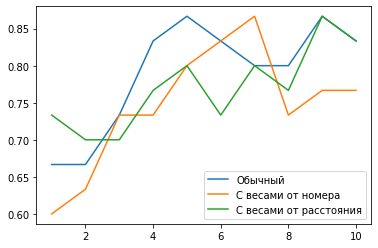

In [82]:
plt.plot(preds1[:, :1], preds1[:, 1:2], label='Обычный')
plt.plot(preds_wnum[:, :1], preds_wnum[:, 1:2], label='C весами от номера')
plt.plot(preds_wdist[:, :1], preds_wdist[:, 1:2], label='C весами от расстояния')
plt.legend()
plt.show()

> Обычный Алгоритм имеет высокую метрику при параметре соседи равным 5
>
> Алгоритм с использованием весов от порядкого номера имеет высокую метрику при параметре соседи равным 7
>
> Алгоритм с использованием весов от расстояния имеет высокую метрику при параметре соседи равным 9

